In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
import os
from pathlib import Path
import random

import pykeen
import matplotlib.pyplot as plt
import torch
from pykeen.datasets import Nations, WN18RR
from pykeen.pipeline import pipeline
from pykeen import predict
import pandas as pd
from tqdm import tqdm
import numpy as np

from pykeen.datasets import PathDataset, EagerDataset
from pykeen.triples import TriplesFactory

from utils import prepare_for_visualization

In [79]:
pd.set_option("display.float_format", lambda x: "%.5f" % x)

In [80]:
WORDNET_PATH = Path("data/plwordnet/plwordnet_4_2.xml")

In [81]:
import plwordnet

wn = plwordnet.load(str(WORDNET_PATH))
print(wn)

Słowosieć
  lexical units: 513410
  synsets: 353585
  relation types: 306
  synset relations: 1477851
  lexical relations: 393137
  emotional annotations: 0
  rich descriptions: 0


In [247]:
wn.synsets[10]

Synset(id=10, definition='', split=1, abstract=False, description='', lexical_units=[LexicalUnit(id=21195, name='samoistny', variant=2, pos_pl='przymiotnik', pos='ADJ', language='pl', domain='jak', tag_count=51, description='##K: og. ##D: dziejący się sam z siebie, nieuwarunkowany. [##P: Część procesów psychofizycznych należy traktować jako samoistne.] [##P: Po ciąży należy się spodziewać, że samoistny cykl owulacyjny powinien powrócić najpóźniej po ok. trzech miesiącach.]', rich_description=None, sentiment=[], synset=...), LexicalUnit(id=7769, name='samoczynny', variant=1, pos_pl='przymiotnik', pos='ADJ', language='pl', domain='jak', tag_count=0, description='##K: og. ##D: taki, który dzieje się, działa, ma miejce bez zewnętrznej ingerencji. [##W: Czasem, zwłaszcza w samolotach, zbiorniki paliwa połączone są z urządzeniem gaśniczym służącym do samoczynnego gaszenia pożaru paliwa.] [##P: Badania tego skrawka terenu dowiodły, że nastąpił tu bardzo znaczący, samoczynny rozwój różnorodnyc

In [179]:
sampled_synsets = set(random.sample(list(wn.synsets.keys()), 170000))
# sampled_synsets

In [220]:
sampled_relations = random.sample(list(sorted(wn.relation_types.keys()))[:10], 10)
sampled_relations = set(list(sorted(wn.relation_types.keys()))[:50])
# sampled_synsets

In [221]:
sampled = [
    (h, r, t)
    for h, r, t, in wn.synset_relations
    if r in sampled_relations and h in sampled_synsets and t in sampled_synsets
]
sampled = np.array(sampled)
len(sampled)

113645

In [222]:
for h, r, t in sampled[:5]:
    print(wn.synsets[h], wn.relation_types[r].name, wn.synsets[t])

{dyskusja.1 dysputa.1 debata.1 debatowanie.3 dysputacja.1} hiperonimia {obrady.1 posiedzenie.7 rada.3 narada.1 sesja.2}
{obrady.1 posiedzenie.7 rada.3 narada.1 sesja.2} hiponimia {dyskusja.1 dysputa.1 debata.1 debatowanie.3 dysputacja.1}
{namowa.1 perswazja.1 inspiracja.1 podszept.1 poduszczenie.1 sugestia.1} hiponimia {porada.1 rada.2 wskazówka.4 wskazanie.6 podpowiedź.1 instrukcja.1 sugestia.2}
{przepiórnik cienkodzioby.1} hiponimia {ptak leśny lub polny.1}
{tekst.3} hiperonimia {rozprawa.2 elaborat.1 traktat.1}


In [223]:
np.array(sampled)[:, [0, 1]]

array([[    712,      11],
       [   2844,      10],
       [  10900,      10],
       ...,
       [  56206,      11],
       [7073372,      10],
       [  56206,      11]])

In [224]:
np.unique(np.array(sampled)[:, [0, 2]]).shape

(59675,)

In [225]:
labeled_sampled = np.array(
    [
        (str(wn.synsets[h]), str(wn.relation_types[r].name), str(wn.synsets[t]))
        for h, r, t, in sampled
    ]
)
labeled_sampled[:2]

array([['{dyskusja.1 dysputa.1 debata.1 debatowanie.3 dysputacja.1}',
        'hiperonimia',
        '{obrady.1 posiedzenie.7 rada.3 narada.1 sesja.2}'],
       ['{obrady.1 posiedzenie.7 rada.3 narada.1 sesja.2}', 'hiponimia',
        '{dyskusja.1 dysputa.1 debata.1 debatowanie.3 dysputacja.1}']],
      dtype='<U374')

In [227]:
triples = TriplesFactory.from_labeled_triples(labeled_sampled)

In [230]:
training, testing = triples.split(0.8)

using automatically assigned random_state=1318084906


In [235]:
dataset = EagerDataset(training, testing)

In [236]:
result = pipeline(
    dataset=dataset,
    model="TransE",
    model_kwargs={"embedding_dim": 32},
    loss="nssa",
    loss_kwargs={"adversarial_temperature": 0.34, "margin": 9},
    optimizer="Adam",
    optimizer_kwargs={"lr": 0.004},
    # training_loop=training_loop,
    # training_loop_kwargs=None,
    # negative_sampler=config["negative_sampler"],
    negative_sampler_kwargs={"num_negs_per_pos": 33},
    training_kwargs=dict(
        num_epochs=25,
        batch_size=512,
        use_tqdm_batch=False,
    ),
    # evaluator=RankBasedEvaluator,
    # evaluator_kwargs=evaluator_kwargs,
    # evaluation_kwargs=evaluation_kwargs,
    # result_tracker=result_tracker,
    # evaluation_fallback=True,
    random_seed=123,
)

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [03:02<00:00,  7.31s/epoch, loss=0.0981, prev_loss=0.0985]
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22.7k/22.7k [10:57<00:00, 34.5triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 658.31s seconds


In [237]:
save_location = "results"  # this directory
result.save_to_directory(save_location)
os.listdir(save_location)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=59657, num_relations=11, create_inverse_triples=False, num_triples=90916) to file:///home/albert/dev/pwr/kg-workshop-23/results/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///home/albert/dev/pwr/kg-workshop-23/results


['trained_model.pkl', 'results.json', 'training_triples', 'metadata.json']

In [238]:
# How to look at the model
model = result.model
model

TransE(
  (loss): NSSALoss()
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(59657, 32)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(11, 32)
    )
  )
  (weight_regularizers): ModuleList()
)

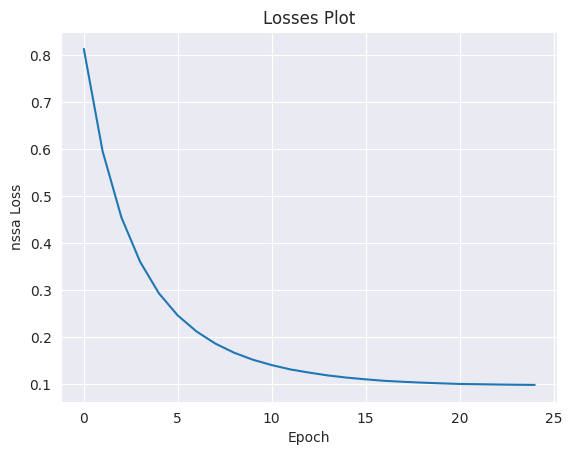

In [239]:
result.plot_losses()
plt.show()

In [240]:
metrics = result.metric_results.to_df()
metrics[(metrics.Side == "both") & (metrics.Type == "realistic")]

,Side,Type,Metric,Value
5,both,realistic,inverse_median_rank,0.50000
14,both,realistic,inverse_harmonic_mean_rank,0.49851
23,both,realistic,z_arithmetic_mean_rank,328.28964
32,both,realistic,median_rank,2.00000
41,both,realistic,harmonic_mean_rank,2.00598
50,both,realistic,arithmetic_mean_rank,3311.30518
59,both,realistic,z_geometric_mean_rank,213.25273
68,both,realistic,z_inverse_harmonic_mean_rank,20244.81119
77,both,realistic,count,45458.00000
86,both,realistic,adjusted_geometric_mean_rank_index,0.99963


In [241]:
result.model.entity_representations

ModuleList(
  (0): Embedding(
    (_embeddings): Embedding(59657, 32)
  )
)

In [260]:
embeddings = result.model.entity_representations[0](torch.arange(dataset.num_entities))
labels = np.array(
    [dataset.training.entity_id_to_label[i] for i in range(dataset.num_entities)]
)

In [261]:
sampled_embeddings_idx = random.sample(list(range(len(embeddings))), 5000)

In [262]:
prepare_for_visualization(
    embeddings.detach().numpy()[sampled_embeddings_idx],
    labels[sampled_embeddings_idx],
    Path("logs/plwordnet"),
)

In [249]:
labels

['{1,3-butadien.1 dwuwinyl.1 erytren.1}',
 '{1,4-benzochinon.1 cykloheksa-2,5-dieno-1,4-dion.1 p-benzochinon.1 parabenzochinon.1}',
 '{A.2}',
 '{A0.1}',
 '{A2.1}',
 '{A4.1}',
 '{A5.1}',
 '{A6.1}',
 '{ABS.1}',
 '{Abakan.3}',
 '{Abchazja.1}',
 '{Abdera.1}',
 '{Aborygen.1 australoid.1}',
 '{Aczyńsk.1}',
 '{Aden.1}',
 '{Adrianopol.1 Edirne.1}',
 '{Adżar.1}',
 '{Adżaria.1 Adżarska Republika Autonomiczna.1}',
 '{Afganistan.1 Islamska Republika Afganistanu.1 Islamskie Państwo Afganistanu.1}',
 '{Afryka Południowa.1}',
 '{Afryka Północno-Wschodnia.1}',
 '{Afryka Wschodnia.1}',
 '{Afryka Środkowa.1}',
 '{Afrykaner.2}',
 '{Afrykańczyk.1 Afrykanin.1}',
 '{Agatka.1}',
 '{Ainur.1}',
 '{Ajnowie.1}',
 '{Ajon.1}',
 '{Akerman.1}',
 '{Akwitania.1}',
 '{Albania.1 Republika Albanii.1}',
 '{Albańczyk.1}',
 '{Aleksandria.1}',
 '{Algieria.1 Algierska Republika Ludowo-Demokratyczna.1}',
 '{Allen.3}',
 '{Alpy.1}',
 '{Alwernia.1}',
 '{Ameryka Łacińska.1 Iberoameryka.1}',
 '{Amerykanin.1}',
 '{Amerykanin.2 Janke